# Imports

In [343]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
import scipy.stats
import math

# Parameters


In [344]:
tiempo_vida_inicial = 0
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo
alpha_damage_propagation = 0.062    #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-2.3))     #Tasa de mortalidad

# Functions

In [345]:
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return (1-x)*(alpha_damage_propagation*x + disease_rate)

In [346]:
def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = 0.1                                         #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

In [347]:
@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 
    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()
        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0

    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

# Implementation

In [296]:
disease_rate = 0.0002
N_total_nodes = [10000]

In [297]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate)


In [298]:
simulaciones_diferentes_nodos = np.empty((len(N_total_nodes)), dtype = object)

for index, N_node in enumerate(N_total_nodes):
    x0 = np.array([0., 2., False])
    num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
    celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N_node,disease_rate ) for i in tqdm(range(num_cel))])
    simulaciones_diferentes_nodos[index] = celulas


100%|██████████| 100000/100000 [01:57<00:00, 851.72it/s]


In [299]:
#N_total_nodes = [30, 90, 300, 600, 900, 1800, 2700]

promedios_simulaciones = np.empty((len(N_total_nodes)), dtype = object)

for index, simulacion_individual in enumerate(simulaciones_diferentes_nodos):

    frailty_index_mean_curve= np.zeros((len(celulas[0])))

    for i in tqdm(np.arange((len(celulas[0])))):
        promedio = np.nanmean(simulaciones_diferentes_nodos[index][:,i,1])/N_total_nodes[index]
        frailty_index_mean_curve[i] = promedio
    
    promedios_simulaciones[index] = frailty_index_mean_curve

100%|██████████| 150/150 [00:00<00:00, 231.40it/s]


In [300]:
import csv
phenomenological_age = []
phenomenological_frailty_index = []
with open("Phenomenological_data.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    phenomenological_age.append(float(fila[0]))
    phenomenological_frailty_index.append(float(fila[1]))

frailty_index_data_age = []
frailty_index_data_index = []
with open("frailty_index_data_GNM.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_data_age.append(float(fila[0]))
    frailty_index_data_index.append(float(fila[1]))

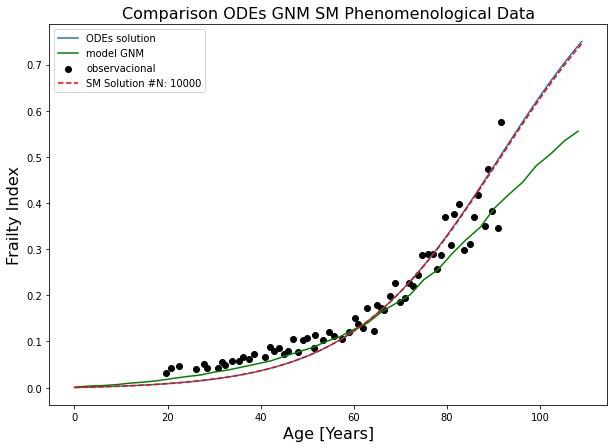

In [301]:
colors = ["red", "yellow", "orange", "red", "blue", "black", "purple"]

plt.figure(figsize = (10,7))
plt.plot(temporal_evolution_differential_equation[0:110], frailty_index_differential_equation[0:110], label = "ODEs solution")
plt.plot(frailty_index_data_age[0:110], frailty_index_data_index[0:110], label = "model GNM", color = "green")
plt.scatter(phenomenological_age, phenomenological_frailty_index, color = "black", label = "observacional")
for i in range(len(promedios_simulaciones)):
    plt.plot(temporal_evolution_differential_equation[0:110] ,promedios_simulaciones[i][0:110], label = f"SM Solution #N: {N_total_nodes[i]}", linestyle = "--", color = colors[i])


plt.title(rf"Comparison ODEs GNM SM Phenomenological Data" , fontsize =16)
plt.xlabel(r"Age [Years]", fontsize =16)
plt.ylabel(r"Frailty Index", fontsize =16)
plt.legend()
plt.savefig("Frailty_index_comportamiento_diferente_D.jpg", dpi = 500)
#plt.savefig("General_Comparison_Frailty_index.jpg", dpi = 500)

# Mortality Rate

In [312]:
gompertz = 4.3*(10**(-2.3))*(frailty_index_differential_equation**(coupling_factor/alpha_damage_propagation))

In [302]:
import csv
phenomenological_age_mortality_rate = []
phenomenological_mortality_rate = []
with open("mortality_rate_phen_data.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    phenomenological_age_mortality_rate.append(float(fila[0]))
    phenomenological_mortality_rate.append(float(fila[1]))

In [303]:
listado = []
suma = 0
for i in range(150):
    listado.append(suma)
    muertos = (np.nansum(simulaciones_diferentes_nodos[0][:,i,2]))
    suma += muertos
listado = np.array(listado)
listado = listado/num_cel

  5%|▌         | 5321/100000 [16:11<4:48:03,  5.48it/s]


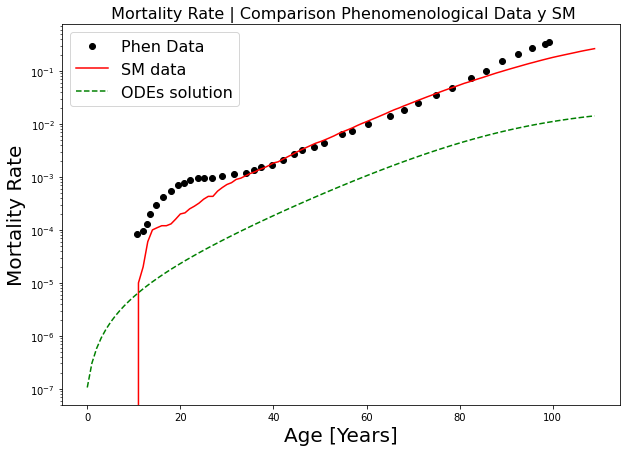

In [327]:
plt.figure(figsize=(10,7))
plt.scatter(phenomenological_age_mortality_rate, phenomenological_mortality_rate, label = "Phen Data", color = "black")
plt.plot(temporal_evolution_differential_equation[0:110], listado[0:110], label = "SM data", color = "red")
plt.plot(temporal_evolution_differential_equation[0:110], gompertz[0:110], label = "ODEs solution", color = "green", linestyle = "--")
plt.yscale("log")

plt.title(rf" Mortality Rate | Comparison Phenomenological Data y SM" , fontsize =16)
plt.xlabel(r"Age [Years]", fontsize =20)
plt.ylabel(r"Mortality Rate", fontsize =20)
plt.legend(fontsize = 16)
plt.savefig("Mortality_Rate_phen_SM_comparison.jpg", dpi = 500)

# Experiments

In [348]:
N_total_steps = [500,1000,2500, 5000]
condicion_inicial = [50.,100.,250., 500.]
disease_rate_steps = [0.00025, 0.0005, 0.001]
simulaciones_gillespie_frailty = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)
solucion_numerica_differential_equations = np.empty((len(N_total_steps)), dtype=object)


In [349]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 

for idx_D, D in enumerate(disease_rate_steps):
    frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, D)
    solucion_numerica_differential_equations[idx_D] = frailty_index_differential_equation

In [350]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 

for idx_D, D in enumerate(disease_rate_steps):
    frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, D)
    solucion_numerica_differential_equations[idx_D] = frailty_index_differential_equation
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([0., condicion_inicial[idx_N], False])
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones_gillespie_frailty[idx_N][idx_D] = celulas

100%|██████████| 4/4 [01:40<00:00, 25.16s/it]


In [351]:
average_curves = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)
for i in tqdm(np.arange((len(simulaciones_gillespie_frailty)))):
    for j in np.arange((len(simulaciones_gillespie_frailty[0]))):
        datos = simulaciones_gillespie_frailty[i][j]
        average = np.zeros((len(datos[0])))
        for k in range(len(datos[0])):
            promedio = np.nanmean(simulaciones_gillespie_frailty[i][j][:,k,1])/N_total_steps[i]
            average[k] = promedio
        average_curves[i][j] = average

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


In [354]:
colors = ["blue", "orange", "brown", "green", "red", "blue", "black", "green"]
for j in range(len(average_curves[0])):
    promedios_simulaciones = average_curves[:, j]
    fig, ax = plt.subplots(figsize = (12,9))
    zoom_region = [0.65, 0.2, 0.25, 0.25]
    ax_zoom = plt.axes(zoom_region)
    ax.plot(temporal_evolution_differential_equation, solucion_numerica_differential_equations[j], label = "ODEs solution")
    ax_zoom.plot(temporal_evolution_differential_equation[110:120], solucion_numerica_differential_equations[j][110:120], label = "ODEs solution")
    for i in range(len(promedios_simulaciones)):
        ax.plot(temporal_evolution_differential_equation, promedios_simulaciones[i], label = f"SM Solution #N: {N_total_steps[i]} IC: {condicion_inicial[i]}", linestyle = "--", color = colors[i])
        ax_zoom.plot(temporal_evolution_differential_equation[110:120], promedios_simulaciones[i][110:120], label = f"SM Solution #N: {N_total_steps[i]}", linestyle = "--", color = colors[i])
    ax.set_title(rf"Frailty Index vs Age | Different # of N| D : {disease_rate_steps[j]} | IC : 10%" , fontsize =16)
    ax.set_xlabel(r"Age [Years]", fontsize =16)
    ax.set_ylabel(r"Frailty Index", fontsize =16)
    ax.legend()
    plt.savefig(f"Frailty_index_different_number_nodes_D_{disease_rate_steps[j]}_condiciones_iniciales_fijas_10_porciento.jpg", dpi = 500)

: 

: 

# Distribuciones condicion inicial

In [336]:
import matplotlib.pyplot as plt
import numpy as np

simulaciones = simulaciones_gillespie_frailty
bins_histograma_65_69 = [21,21,30,22,29,25,30,30,31,30,29]
bins_histograma_80_85 = [21,21,30,22,29,25,30,30,35,27,30]
bins_histograma_90_95 = [21,21,30,22,29,25,30,30,25,33,22]
bins_histograma_100_105 = [21,21,30,22,29,25,30,30,30,28,32]

datos_65_69 = np.empty((len(N_total_steps)), dtype=object)
hist_65_69 = np.empty((len(N_total_steps)), dtype=object)
max_points_65_69 = np.empty((len(N_total_steps)), dtype=object)

datos_80_85 = np.empty((len(N_total_steps)), dtype=object)
hist_80_85 = np.empty((len(N_total_steps)), dtype=object)
max_points_80_85 = np.empty((len(N_total_steps)), dtype=object)

datos_90_95 = np.empty((len(N_total_steps)), dtype=object)
hist_90_95 = np.empty((len(N_total_steps)), dtype=object)
max_points_90_95 = np.empty((len(N_total_steps)), dtype=object)

datos_100_105 = np.empty((len(N_total_steps)), dtype=object)
hist_100_105 = np.empty((len(N_total_steps)), dtype=object)
max_points_100_105 = np.empty((len(N_total_steps)), dtype=object)

for i in range(0, len(N_total_steps)):
    dato_65_69 = np.concatenate((simulaciones[i][0][:,55:59,1]))
    dato_65_69 = dato_65_69[~np.isnan(dato_65_69)]

    datos_65_69[i] = dato_65_69
    hist, bin = np.histogram(datos_65_69[i], density=True, bins = bins_histograma_65_69[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_65_69[i] = hist*100
    max_points_65_69[i] = max_points_filtered_a/N_total_steps[i]


####
    dato_80_85 = np.concatenate((simulaciones[i][0][:,70:75,1]))
    dato_80_85 = dato_80_85[~np.isnan(dato_80_85)]

    datos_80_85[i] = dato_80_85
    hist, bin = np.histogram(datos_80_85[i], density=True, bins = bins_histograma_80_85[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_80_85[i] = hist*100
    max_points_80_85[i] = max_points_filtered_a/N_total_steps[i]

###
    dato_90_95 = np.concatenate((simulaciones[i][0][:,80:85,1]))
    dato_90_95 = dato_90_95[~np.isnan(dato_90_95)]

    datos_90_95[i] = dato_90_95
    hist, bin = np.histogram(datos_90_95[i], density=True, bins = bins_histograma_90_95[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_90_95[i] = hist*100
    max_points_90_95[i] = max_points_filtered_a/N_total_steps[i]

####

    dato_100_105 = np.concatenate((simulaciones[i][0][:,90:95,1]))
    dato_100_105 = dato_100_105[~np.isnan(dato_100_105)]

    datos_100_105[i] = dato_100_105
    hist, bin = np.histogram(datos_100_105[i], density=True, bins = bins_histograma_100_105[i] )


    max_point = bin[:-1] + np.diff(bin)/2
    max_points_filtered_a = max_point[hist > 0]

    hist = hist[hist > 0]

    hist_100_105[i] = hist*100
    max_points_100_105[i] = max_points_filtered_a/N_total_steps[i]

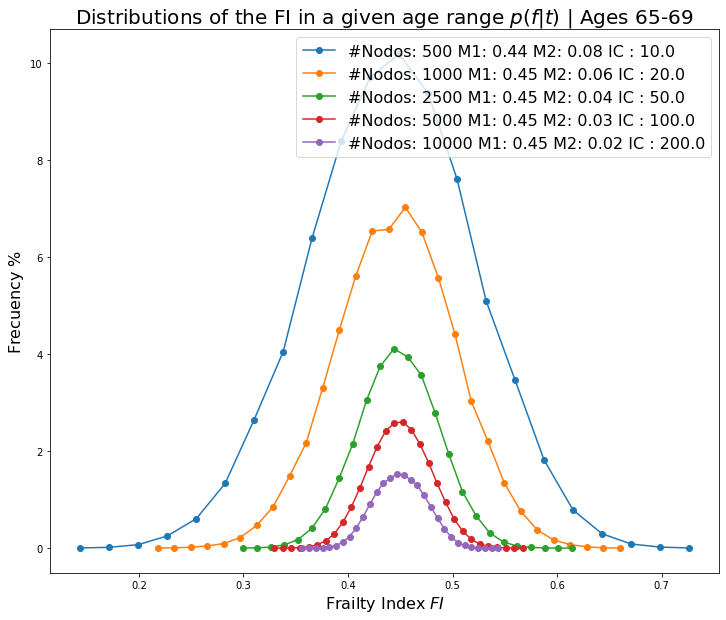

In [338]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 65-69", fontsize = 20)
for i in range(3, len(N_total_steps)):

    plt.plot(max_points_65_69[i], hist_65_69[i]*10, marker='o', label = f"#Nodos: {N_total_steps[i]} M1: {np.round(np.mean(datos_65_69[i]/N_total_steps[i]),2)} M2: {np.round(np.std(datos_65_69[i]/N_total_steps[i]),2)} IC : {condicion_inicial[i]}")

#plt.scatter(frailty_index_GNM_data_65_69, frecuency_GNM_data_65_69, color = "red")
#plt.plot(frailty_index_GNM_data_65_69, frecuency_GNM_data_65_69, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig("Comparacion_GNM_stochastic_65_69_valores_grandes_condicion_inicial_2_porciento.jpg", dpi = 500)
plt.show()

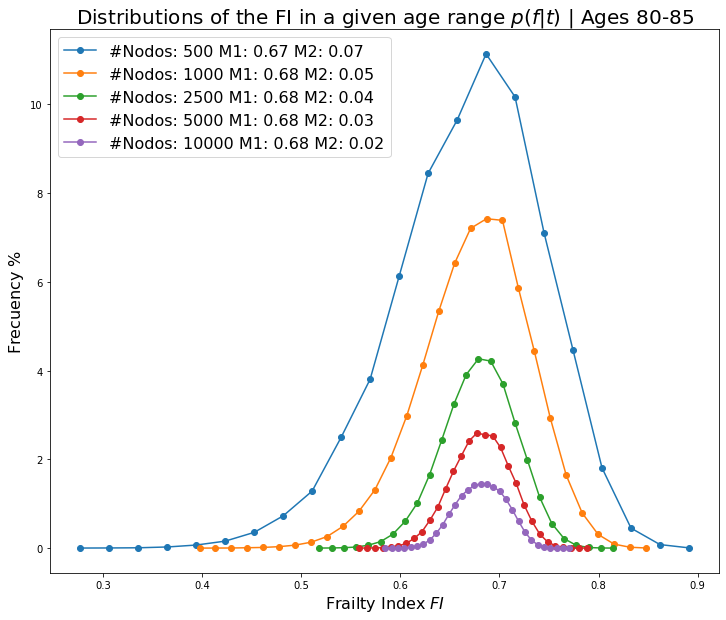

In [340]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 80-85", fontsize = 20)
for i in range(3, len(N_total_steps)):

    plt.plot(max_points_80_85[i], hist_80_85[i]*10, marker='o', label = f"#Nodos: {N_total_steps[i]} M1: {np.round(np.mean(datos_80_85[i]/N_total_steps[i]),2)} M2: {np.round(np.std(datos_80_85[i]/N_total_steps[i]),2)}")

#plt.scatter(frailty_index_GNM_data_80_85, frecuency_GNM_data_80_85, color = "red")
#plt.plot(frailty_index_GNM_data_80_85, frecuency_GNM_data_80_85, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig("Comparacion_GNM_stochastic_80_85_valores_grandes_condicion_inicial_2_porciento.jpg", dpi = 500)
plt.show()

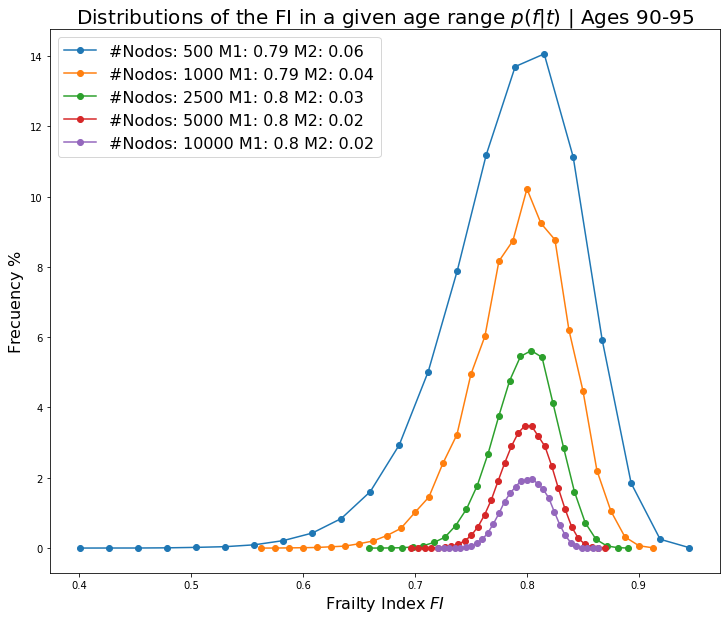

In [341]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 90-95", fontsize = 20)
for i in range(3, len(N_total_steps)):

    plt.plot(max_points_90_95[i], hist_90_95[i]*10, marker='o', label = f"#Nodos: {N_total_steps[i]} M1: {np.round(np.mean(datos_90_95[i]/N_total_steps[i]),2)} M2: {np.round(np.std(datos_90_95[i]/N_total_steps[i]),2)}")

#plt.scatter(frailty_index_GNM_data_90_95, frecuency_GNM_data_90_95, color = "red")
#plt.plot(frailty_index_GNM_data_90_95, frecuency_GNM_data_90_95, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig("Comparacion_GNM_stochastic_90_95_valores_grandes_condicion_inicial_2_porciento.jpg", dpi = 500)
plt.show()

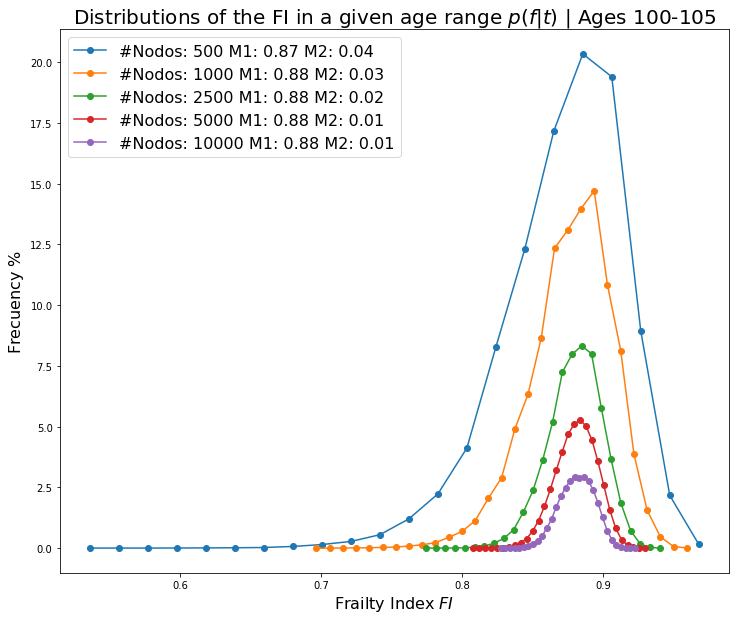

In [342]:
plt.figure(figsize=(12,10))
plt.title(r"Distributions of the FI in a given age range $p(f|t)$ | Ages 100-105", fontsize = 20)
for i in range(3, len(N_total_steps)):

    plt.plot(max_points_100_105[i], hist_100_105[i]*10, marker='o', label = f"#Nodos: {N_total_steps[i]} M1: {np.round(np.mean(datos_100_105[i]/N_total_steps[i]),2)} M2: {np.round(np.std(datos_100_105[i]/N_total_steps[i]),2)}")

#plt.scatter(frailty_index_GNM_data_100_105, frecuency_GNM_data_100_105, color = "red")
#plt.plot(frailty_index_GNM_data_100_105, frecuency_GNM_data_100_105, label = "GNM data", color = "red")

plt.xlabel(r'Frailty Index $FI$', fontsize = 16)
plt.ylabel(r'Frecuency $\%$', fontsize = 16)
plt.legend(fontsize = 16)
plt.savefig("Comparacion_GNM_stochastic_100_105_valores_grandes_condicion_inicial_2_porciento.jpg", dpi = 500)
plt.show()